<a href="https://colab.research.google.com/github/LuisGuillermoRL/Practicas_CDSI/blob/main/Pr%C3%A1ctica_de_Se%C3%B1as.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mediapipe

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn import metrics

In [ ]:
import mediapipe as mp
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
#help(mp_hands.Hands)

###Importamos una imagen de prueba





In [ ]:
prueba = cv2.imread('/content/drive/MyDrive/Dataset sensores/S1/A/A-1-1.jpg')

In [ ]:
height, width, _ = prueba.shape #_ es de 3 bandas, BGR

Obtenemos los puntos de las manos

In [ ]:
with mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1
    ) as hands:
    # Convert the BGR image to RGB, flip the image around y-axis for correct
    # handedness output and process it with MediaPipe Hands.
    results = hands.process(cv2.flip(cv2.cvtColor(prueba, cv2.COLOR_BGR2RGB), 1))
    keypoint_pos = []
for hand_landmarks in results.multi_hand_landmarks:
  for i in range(21):
    x = int(hand_landmarks.landmark[i].x * width) #width
    y = int(hand_landmarks.landmark[i].y * height)
    print(x,y)
    keypoint_pos.append((x, y))

88 250
144 253
198 228
240 204
275 200
195 174
212 138
193 164
183 188
163 156
179 119
158 160
155 180
130 145
143 110
129 151
125 171
95 139
103 108
101 135
103 154


###Ploteamos la mano

In [ ]:
from google.colab.patches import cv2_imshow

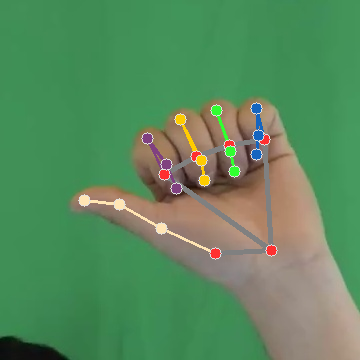

In [ ]:
image_hight, image_width, _ = prueba.shape
annotated_image = cv2.flip(prueba.copy(), 1)
for hand_landmarks in results.multi_hand_landmarks:
  mp_drawing.draw_landmarks(
          annotated_image,
          hand_landmarks,
          mp_hands.HAND_CONNECTIONS,
          mp_drawing_styles.get_default_hand_landmarks_style(),
          mp_drawing_styles.get_default_hand_connections_style())
  cv2_imshow(cv2.flip(annotated_image, 1))

###Generalizando

In [ ]:
def extr_points(file_name):
  img = cv2.imread(file_name)
  width, height,_ = img.shape
  with mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1
    ) as hands:
    results = hands.process(cv2.flip(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 1))

    if results.multi_hand_landmarks is not None:
      puntos = []
      for hand_landmarks in results.multi_hand_landmarks:
        for i in range(21):
          x = int(hand_landmarks.landmark[i].x * width)
          y = int(hand_landmarks.landmark[i].y * height)
          puntos.append((x, y))

      frame_array = np.array(puntos)
      return frame_array.flatten()

In [ ]:
def load_data(ospath):
  features = []
  labels = []
  for file in glob(ospath):
    base_name = os.path.basename(file)
    individual_label = base_name.split("-")[0]
    features_list = extr_points(file)
    if features_list is not None:
      features.append(features_list)
      labels.append(individual_label)
  return np.array(features), labels

Obtenemos las cracterísticas de todas las manos, así como las etiquetas:

In [ ]:
Caract, Etiq = load_data("/content/drive/MyDrive/Dataset sensores/*/*/*.jpg") ###Podemos corroborar con una imagen particular
Caract.shape

(490, 42)

###Modelación



In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(Caract, Etiq, test_size = 0.2 , random_state = 0)

KNN seleccionado

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier_kn = KNeighborsClassifier(n_neighbors=15, metric = "minkowski", p=2)

In [ ]:
classifier_kn.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=15)

In [ ]:
Y_pred = classifier_kn.predict(X_test)

Accuracy y matriz de confusión

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(Y_test,Y_pred)
cm

array([[20,  0,  0,  3,  0],
       [ 0, 20,  0,  1,  0],
       [ 0,  1, 21,  1,  0],
       [ 0,  2,  0, 15,  0],
       [ 0,  0,  0,  1, 13]])

In [ ]:
print(accuracy_score(Y_test,y_pred=Y_pred))
print(classification_report(Y_test,Y_pred))

0.9081632653061225
              precision    recall  f1-score   support

           A       1.00      0.87      0.93        23
           E       0.87      0.95      0.91        21
           I       1.00      0.91      0.95        23
           O       0.71      0.88      0.79        17
           U       1.00      0.93      0.96        14

    accuracy                           0.91        98
   macro avg       0.92      0.91      0.91        98
weighted avg       0.92      0.91      0.91        98



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


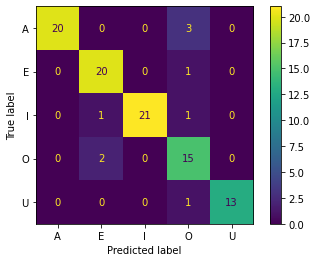

In [ ]:
plot_confusion_matrix(classifier_kn, X_test, Y_test)
plt.show()

Aplicando k-fold cross validation

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
accuracies = cross_val_score(estimator = classifier_kn, X = X_train, y = Y_train, cv = 10)

In [ ]:
accuracies

array([0.85      , 0.925     , 0.8974359 , 0.94871795, 0.97435897,
       0.94871795, 0.97435897, 0.94871795, 0.94871795, 0.94871795])

In [ ]:
accuracies.mean()

0.9364743589743589

#Importación de archivos externos (recolectados manualmente)
**Observe que su recolección, al igual que en la práctica 1, no es en un ambiente controlado.**

Para elevar la dificultad se nos pidió capturar las manos normales (como la de la figura de arriba) y rotadas, con el fin de evaluar el desempeño del modelo en manos rotadas y sin rotar (normales).


In [ ]:
mr = cv2.imread('/content/drive/MyDrive/Tareas CDSI/Manos/Manos_rotadas/A-r1.jpeg')

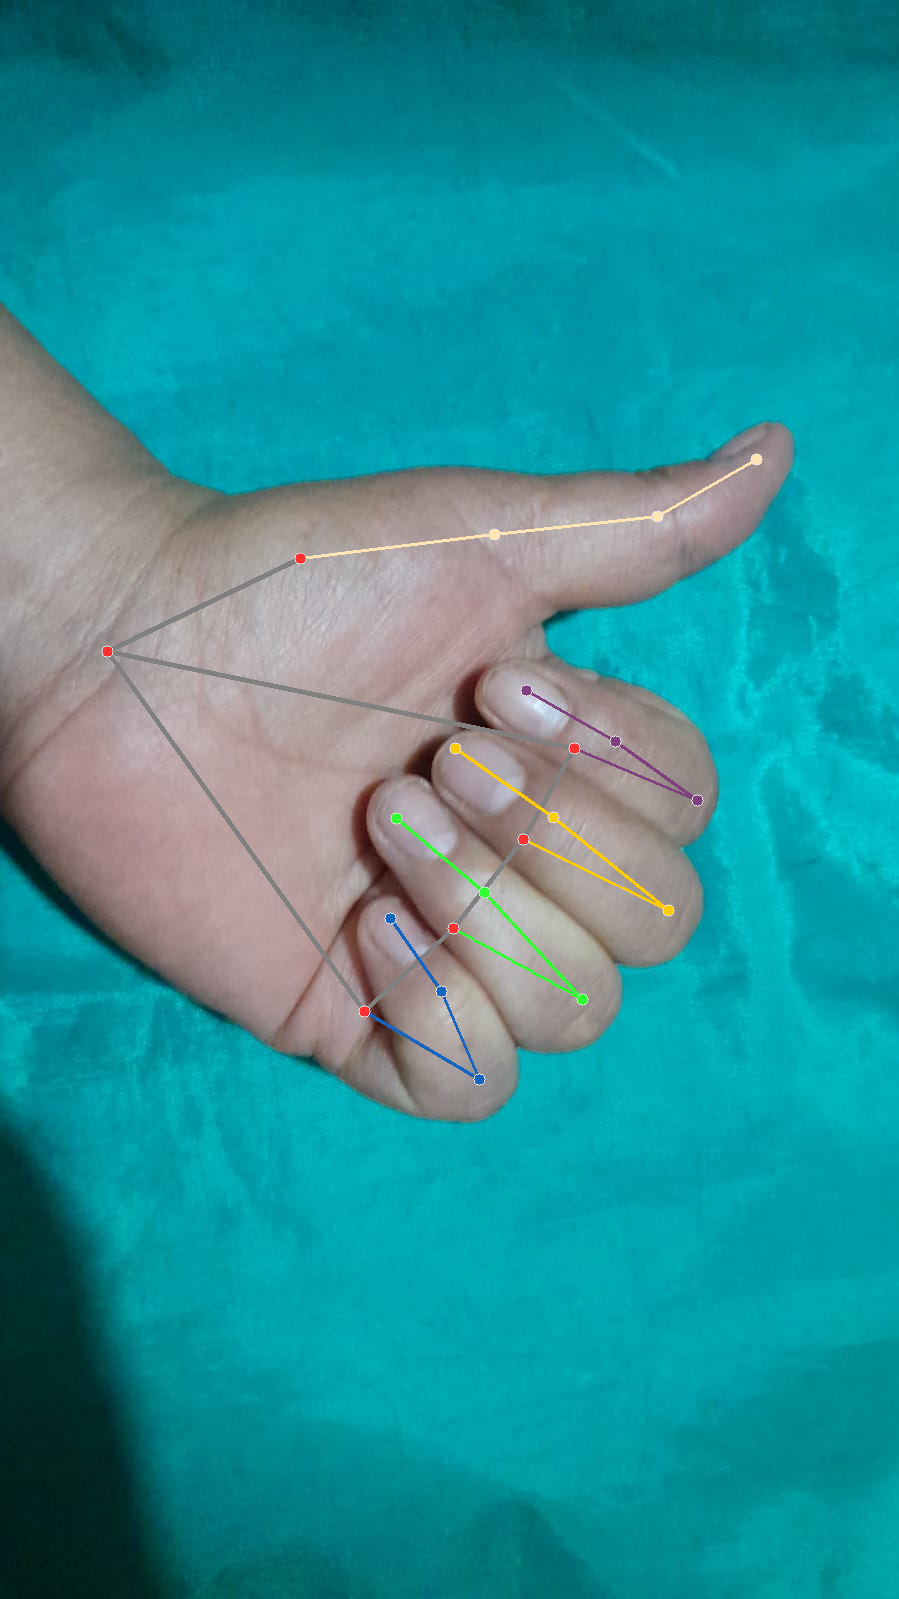

In [ ]:
with mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1
    ) as hands:
  results_mr = hands.process(cv2.flip(cv2.cvtColor(mr, cv2.COLOR_BGR2RGB), 1))
#hight_mr, width_mr, _ = mr.shape
  annotated_image_mr = cv2.flip(mr.copy(), 1)
  for hand_landmarks in results_mr.multi_hand_landmarks:
   mp_drawing.draw_landmarks(
          annotated_image_mr,
          hand_landmarks,
          mp_hands.HAND_CONNECTIONS,
          mp_drawing_styles.get_default_hand_landmarks_style(),
          mp_drawing_styles.get_default_hand_connections_style())
  cv2_imshow(cv2.flip(annotated_image_mr, 1))

Evaluamos con 5 imágenes

In [ ]:
manos_r, labels_r = load_data("/content/drive/MyDrive/Tareas CDSI/Manos/Manos_rotadas/*.jpeg")
manos_r.shape


(5, 42)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/l

              precision    recall  f1-score   support

           A       0.00      0.00      0.00       1.0
           E       0.00      0.00      0.00       1.0
           I       0.00      0.00      0.00       1.0
           O       0.00      0.00      0.00       1.0
           U       0.00      0.00      0.00       1.0

    accuracy                           0.00       5.0
   macro avg       0.00      0.00      0.00       5.0
weighted avg       0.00      0.00      0.00       5.0



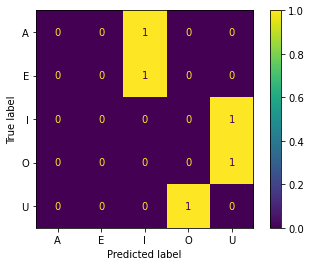

In [ ]:
plot_confusion_matrix(classifier_kn,manos_r,labels_r)
pred_mr = classifier_kn.predict(manos_r)
print(metrics.classification_report(labels_r,pred_mr))

Ahora con manos sin estar rotadas como la del sig. ejemplo.

In [ ]:
m = cv2.imread('/content/drive/MyDrive/Tareas CDSI/Manos/Manos_sin_rotar/O-p1.jpeg')

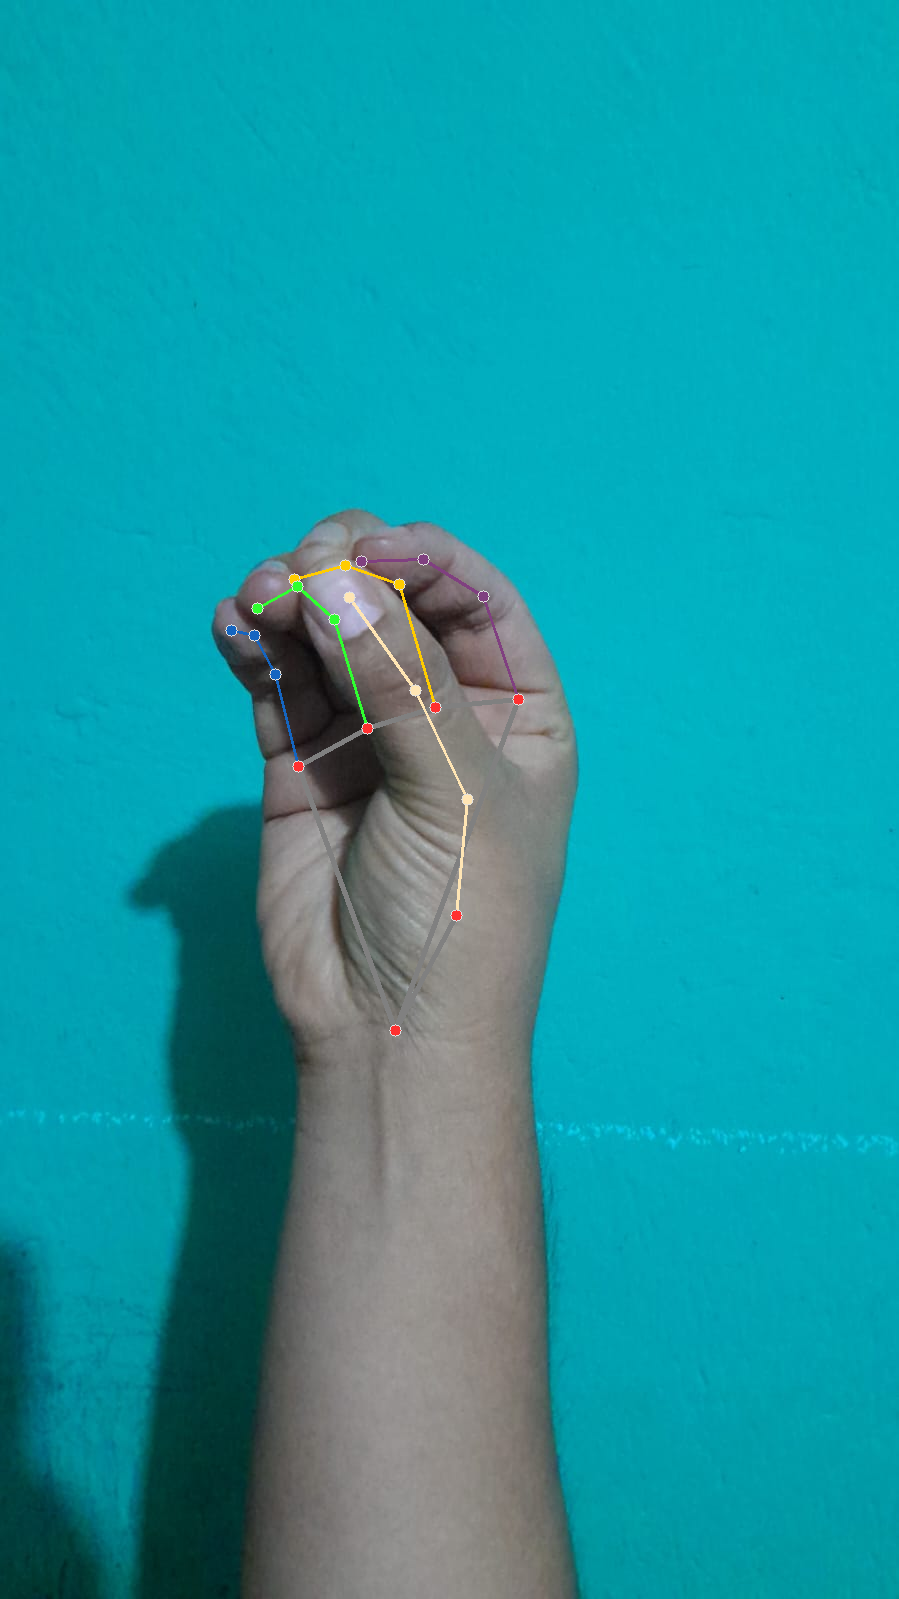

In [ ]:
with mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1
    ) as hands:
  results_m = hands.process(cv2.flip(cv2.cvtColor(m, cv2.COLOR_BGR2RGB), 1))

  annotated_image_m = cv2.flip(m.copy(), 1)
  for hand_landmarks in results_mr.multi_hand_landmarks:
   mp_drawing.draw_landmarks(
          annotated_image_m,
          hand_landmarks,
          mp_hands.HAND_CONNECTIONS,
          mp_drawing_styles.get_default_hand_landmarks_style(),
          mp_drawing_styles.get_default_hand_connections_style())
  cv2_imshow(cv2.flip(annotated_image_m, 1))

Evaluamos las 10 imágenes

In [ ]:
manos, labels = load_data("/content/drive/MyDrive/Tareas CDSI/Manos/Manos_sin_rotar/*.jpeg")
manos.shape

(9, 42)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/l

              precision    recall  f1-score   support

           A       0.00      0.00      0.00         2
           E       0.00      0.00      0.00         2
           I       0.00      0.00      0.00         1
           O       0.29      1.00      0.44         2
           U       1.00      0.50      0.67         2

    accuracy                           0.33         9
   macro avg       0.26      0.30      0.22         9
weighted avg       0.29      0.33      0.25         9



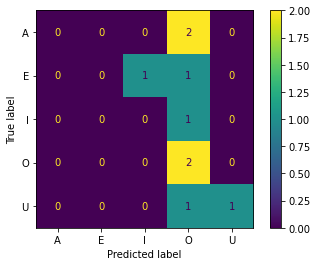

In [ ]:
plot_confusion_matrix(classifier_kn,manos,labels)
pred_m = classifier_kn.predict(manos)
print(metrics.classification_report(labels,pred_m))